<a href="https://colab.research.google.com/github/Daeijavad/MNIST/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern Recognition in MNIST dataset Using 5 Methods
### Methods Include SVM, K-nearest neighborhood, Decision Tree, Random Forest And MLP
### Also Feature Extraction and Feature Selection Has Been Applyed

In [ ]:
%matplotlib inline

import numpy as np

import sklearn
from sklearn.datasets import fetch_openml
from sklearn import svm, decomposition, feature_selection, neighbors
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.measure import block_reduce
from skimage.feature import canny

import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
sns.set()

# 1.   Feature Extraction



In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, shuffle=True)

In [ ]:
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 784)
y_train: (60000,)
X_test (10000, 784)
y_test (10000,)


## 1.1. PCA

we use PCA for MLP

In [ ]:
n_components = 75
pca = decomposition.PCA(n_components=n_components, whiten=True)
X_train_pca = pca.fit_transform(X_train)
print('X_pca:', X_train_pca.shape)

X_pca: (60000, 75)


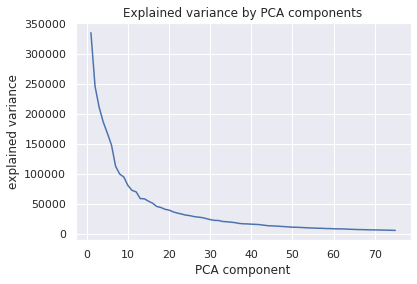

In [ ]:
plt.figure()
plt.plot(np.arange(n_components)+1, pca.explained_variance_)
plt.title('Explained variance by PCA components')
plt.ylabel('explained variance')
plt.xlabel('PCA component');

## 1.2.  Canny filter

in this part we first downsample images to have size = (14,14)
then we apply canny filter

we use it in 1-Nearest Neighborhood

In [ ]:
X_train_img = X_train.reshape(-1, 28, 28)
X_test_img = X_test.reshape(-1, 28, 28)
filter_size = 2
X_train_img_downsampled = block_reduce(X_train_img,  block_size=(1, filter_size, filter_size), func=np.mean)
X_test_img_downsampled = block_reduce(X_test_img,  block_size=(1, filter_size, filter_size), func=np.mean)

print('X_train_img:', X_train_img.shape)
print('X_train_img_downsampled:', X_train_img_downsampled.shape)

X_train_img: (60000, 28, 28)
X_train_img_downsampled: (60000, 14, 14)


In [ ]:
sigma = 1.0
X_train_img_canny = np.zeros(X_train_img.shape)
X_test_img_canny = np.zeros(X_test_img.shape)
for i in range(X_train_img.shape[0]):
    X_train_img_canny[i,:,:] = canny(X_train_img[i,:,:], sigma=sigma)
for i in range(X_test_img.shape[0]):
    X_test_img_canny[i,:,:] = canny(X_test_img[i,:,:], sigma=sigma)
print('X_train_img_canny:', X_train_img_canny.shape)

X_train_img_canny: (60000, 28, 28)


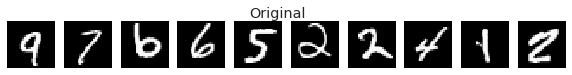

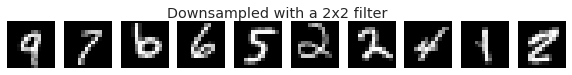

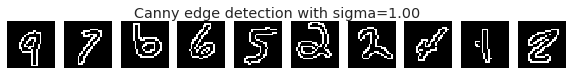

In [ ]:
pltsize=1

plt.figure(figsize=(10*pltsize, pltsize))
plt.suptitle('Original')
plt.subplots_adjust(top=0.8)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train_img[i,:,:], cmap="gray", interpolation='none')

plt.figure(figsize=(10*pltsize, pltsize))
plt.suptitle('Downsampled with a %dx%d filter' % (filter_size, filter_size))
plt.subplots_adjust(top=0.8)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train_img_downsampled[i,:,:], cmap="gray", interpolation='none')
    
plt.figure(figsize=(10*pltsize, pltsize))
plt.suptitle('Canny edge detection with sigma=%.2f' % sigma)
plt.subplots_adjust(top=0.8)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train_img_canny[i,:,:], cmap="gray", interpolation='none')

# 2. Feature Selection
removing "Low Variance" components

we use it in SVM

Text(0.5, 0, 'component')

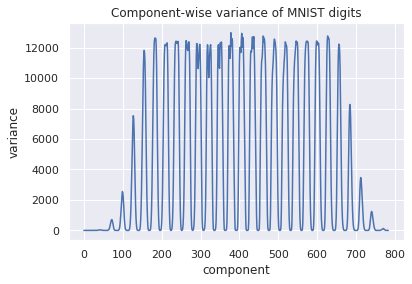

In [ ]:
variances = np.var(X_train, axis=0)
plt.figure()
plt.plot(variances)
plt.title('Component-wise variance of MNIST digits')
plt.ylabel('variance')
plt.xlabel('component')

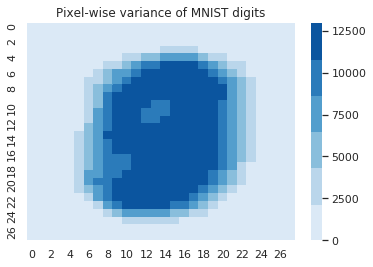

In [ ]:
plt.figure()
sns.heatmap(variances.reshape(28,28), cmap=sns.color_palette("Blues"))
plt.title('Pixel-wise variance of MNIST digits')
plt.grid(False)

In [ ]:
variance_threshold = 1000
lv = feature_selection.VarianceThreshold(threshold=variance_threshold)
X_train_lv = lv.fit_transform(X_train)
print('X_lv:', X_train_lv.shape)

X_lv: (60000, 411)


# 3. SVM

In [ ]:
C = 1.0
clf_lsvm = svm.LinearSVC(C=C)
clf_lsvm.fit(X_train_lv, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
X_test_lv = lv.transform(X_test)
pred_lsvm = clf_lsvm.predict(X_test_lv)
print('Predicted', len(pred_lsvm), 'digits with accuracy:', accuracy_score(y_test, pred_lsvm))

Predicted 10000 digits with accuracy: 0.8121


Confusion matrix (rows: true classes; columns: predicted classes):

[[ 928    0    6    8    3   27    6    1    0   15]
 [   0 1047   14    4    1    7    0    3    2   19]
 [   9   13  864   60   21   11   15   24    7   21]
 [   1    5   31  871    2   44    0    6    4   54]
 [   2    0    2    0  827    7    3    1    0  120]
 [  13    1   10   53   16  709   10    6    3   82]
 [   7    2   21    3   23   44  843    0    1    3]
 [   6    2    5   10    5    5    0  872    0  153]
 [   5   30   39  111   21  182   12    4  204  364]
 [   5    0    0    9   21    5    0    7    1  956]]



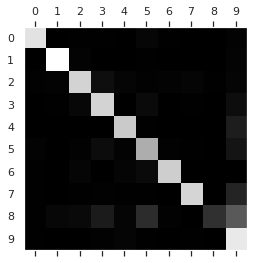

In [ ]:
labels=[str(i) for i in range(10)]
print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, pred_lsvm, labels=labels)
print(cm); print()
plt.matshow(cm, cmap=plt.cm.gray)
plt.xticks(range(10))
plt.yticks(range(10))
plt.grid(None)
plt.show()

In [ ]:
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))
print(classification_report(y_test, pred_lsvm, labels=labels))

0: 0.9336
1: 0.9544
2: 0.8268
3: 0.8556
4: 0.8597
5: 0.7852
6: 0.8902
7: 0.8242
8: 0.2099
9: 0.9522
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       994
           1       0.95      0.95      0.95      1097
           2       0.87      0.83      0.85      1045
           3       0.77      0.86      0.81      1018
           4       0.88      0.86      0.87       962
           5       0.68      0.79      0.73       903
           6       0.95      0.89      0.92       947
           7       0.94      0.82      0.88      1058
           8       0.92      0.21      0.34       972
           9       0.53      0.95      0.69      1004

    accuracy                           0.81     10000
   macro avg       0.85      0.81      0.80     10000
weighted avg       0.85      0.81      0.80     10000



# 4. 1-Nearest Neighborhood




In [ ]:
n_neighbors = 1
clf_nn = neighbors.KNeighborsClassifier(n_neighbors)
clf_nn.fit(X_train_img_canny.reshape(X_train_img_canny.shape[0],X_train_img_canny.shape[1]*X_train_img_canny.shape[2]), y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
pred_nn = clf_nn.predict(X_test_img_canny.reshape(X_test_img_canny.shape[0],X_test_img_canny.shape[1]*X_test_img_canny.shape[2]))

In [ ]:
print('Predicted', len(pred_nn), 'digits with accuracy:',
      accuracy_score(y_test[:len(pred_nn)], pred_nn))

Predicted 10000 digits with accuracy: 0.9173


Confusion matrix (rows: true classes; columns: predicted classes):

[[ 977    1    0    2    0    2    6    2    2    2]
 [   0 1087    2    1    1    0    2    2    0    2]
 [  11   34  938   15    3    1    6   27    7    3]
 [   3    7   18  912    0   42    3   13   12    8]
 [   0   18    1    0  879    0    5    8    0   51]
 [   8    3    4   56    4  788   18    4    3   15]
 [  14    3    0    1    2    9  917    0    1    0]
 [   0   18    4    0    4    0    0 1012    1   19]
 [  14   24   11   37    9   42    8    5  796   26]
 [   5    2    2    7   40    4    1   76    0  867]]



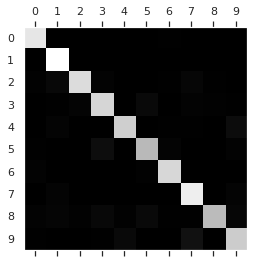

In [ ]:
print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, pred_nn, labels=labels)
print(cm); print()
plt.matshow(cm, cmap=plt.cm.gray)
plt.xticks(range(10))
plt.yticks(range(10))
plt.grid(None)
plt.show()

In [ ]:
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))
print(classification_report(y_test, pred_nn, labels=labels))

0: 0.9829
1: 0.9909
2: 0.8976
3: 0.8959
4: 0.9137
5: 0.8726
6: 0.9683
7: 0.9565
8: 0.8189
9: 0.8635
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       994
           1       0.91      0.99      0.95      1097
           2       0.96      0.90      0.93      1045
           3       0.88      0.90      0.89      1018
           4       0.93      0.91      0.92       962
           5       0.89      0.87      0.88       903
           6       0.95      0.97      0.96       947
           7       0.88      0.96      0.92      1058
           8       0.97      0.82      0.89       972
           9       0.87      0.86      0.87      1004

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



# 5. Decision Tree

In [ ]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
pred_dt = clf_dt.predict(X_test)
print('Predicted', len(pred_dt), 'digits with accuracy:', accuracy_score(y_test, pred_dt))

Predicted 10000 digits with accuracy: 0.8746


# 6. Random Forest

In [ ]:
n_estimators = 10
clf_rf = RandomForestClassifier(n_estimators=n_estimators)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
pred_rf = clf_rf.predict(X_test)
print('Predicted', len(pred_rf), 'digits with accuracy:', accuracy_score(y_test, pred_rf))

Predicted 10000 digits with accuracy: 0.9482


In [ ]:
labels=[str(i) for i in range(10)]
print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, pred_rf, labels=labels)
print(cm); print()

print('Classification accuracy for each class:'); print()

Confusion matrix (rows: true classes; columns: predicted classes):

[[ 971    0    3    3    1    3    6    2    4    1]
 [   0 1072    7    4    1    0    2    4    4    3]
 [   3    3  994    8    5    3    8   11    8    2]
 [   4    3   26  944    2   14    2    9    9    5]
 [   2    0    3    1  932    0    3    3    2   16]
 [   5    1    4   26    3  843    4    2    8    7]
 [   5    2    8    2    4   15  906    0    5    0]
 [   4    6   10    2    6    1    0 1016    0   13]
 [   8    5   18   15    6   14   12    0  882   12]
 [   4    3    4   11   26   10    1   12   11  922]]

Classification accuracy for each class:



In [ ]:
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))
print(classification_report(y_test, pred_rf, labels=labels))

0: 0.9769
1: 0.9772
2: 0.9512
3: 0.9273
4: 0.9688
5: 0.9336
6: 0.9567
7: 0.9603
8: 0.9074
9: 0.9183
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       994
           1       0.98      0.98      0.98      1097
           2       0.92      0.95      0.94      1045
           3       0.93      0.93      0.93      1018
           4       0.95      0.97      0.96       962
           5       0.93      0.93      0.93       903
           6       0.96      0.96      0.96       947
           7       0.96      0.96      0.96      1058
           8       0.95      0.91      0.93       972
           9       0.94      0.92      0.93      1004

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



# 7. MLP

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [ ]:
X_test_pca = pca.fit_transform(X_test)

# one-hot encoding:
Y_train = keras.utils.to_categorical(y_train, 10)
Y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
# Model initialization:
model = Sequential()

model.add(Dense(units=100, input_dim=784))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 100)               78500     
_________________________________________________________________
activation_10 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, 
                    Y_train, 
                    epochs=15, 
                    validation_data=(X_test, Y_test),
                    batch_size=32,
                    verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
 - 7s - loss: 7.8699 - acc: 0.5075 - val_loss: 5.7303 - val_acc: 0.6420
Epoch 2/15
 - 6s - loss: 5.2753 - acc: 0.6698 - val_loss: 3.3241 - val_acc: 0.7925
Epoch 3/15
 - 6s - loss: 3.9985 - acc: 0.7497 - val_loss: 3.2009 - val_acc: 0.8000
Epoch 4/15
 - 6s - loss: 3.7749 - acc: 0.7641 - val_loss: 3.3755 - val_acc: 0.7888
Epoch 5/15
 - 6s - loss: 3.5393 - acc: 0.7790 - val_loss: 3.0250 - val_acc: 0.8115
Epoch 6/15
 - 6s - loss: 3.6156 - acc: 0.7743 - val_loss: 3.6428 - val_acc: 0.7728
Epoch 7/15
 - 7s - loss: 3.3993 - acc: 0.7876 - val_loss: 2.4274 - val_acc: 0.8480
Epoch 8/15
 - 6s - loss: 3.0135 - acc: 0.8115 - val_loss: 1.7436 - val_acc: 0.8908
Epoch 9/15
 - 6s - loss: 2.7691 - acc: 0.8269 - val_loss: 2.0442 - val_acc: 0.8721
Epoch 10/15
 - 6s - loss: 2.5531 - acc: 0.8403 - val_loss: 1.6915 - val_acc: 0.8943
Epoch 11/15
 - 7s - loss: 2.4079 - acc: 0.8492 - val_loss: 1.6931 - val_acc: 0.8941
Epoch 12/15
 - 6s - loss: 2.4144 - 

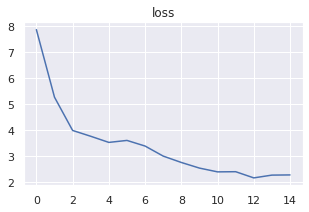

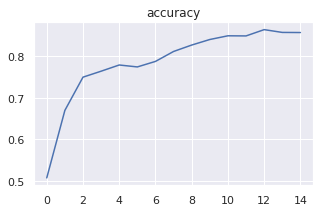

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy');